### Import modules

In [848]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import sys
sys.path.insert(0,r"C:\Users\nanw0\GoogleDrive\SLAC\SLAC-Diling\8. 20 Winter\Beam_propagation\WPG\WPG-develop")

%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [849]:
#Importing necessary modules:
import os
import sys
import copy

sys.path.insert(0,os.path.join('..','..'))
#sys.path.insert('../..')

import time
import numpy as np
import pylab as plt

# import auxiliar functions
%autoreload 2
from Auxiliary import *


### Defining initial wavefront and writing electric field data to h5-file


*****defining initial wavefront and writing electric field data to h5-file...
sigX: 11.5um, waist_fwhm: 27.08um
far field divergence_fwhm: 3.0urad
generating incident wavefront
saving incident wavefront
finished in 0.5s
6739.942505580438 6744.036919475367
beam divergence: 5.094urad


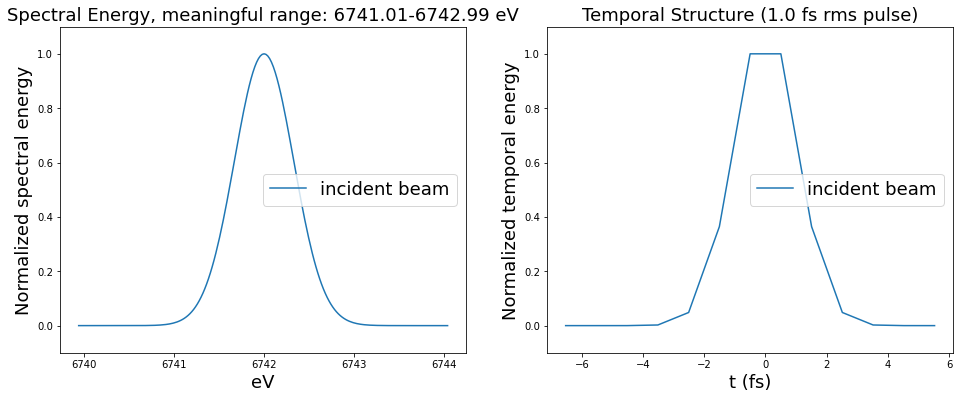

In [884]:
print('*****defining initial wavefront and writing electric field data to h5-file...')
strDataFolderName = 'WPG_output/temporal/' # output data sub-folder name
if not os.path.exists(strDataFolderName):
    mkdir_p(strDataFolderName)

''' beam parameter '''
ekev = 6.742           # Energy [keV]

qnC = 0.1              # e-bunch charge, [nC]
pulse_duration = 1.e-15
pulseEnergy = 0.5e-3  # total pulse energy, J

''' distance to first OE '''
z1 = 50.0
# calculate beam fwhm
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)
k = 2*np.sqrt(2*np.log(2))
sigX = 12.4e-10*k/(ekev*4*np.pi*theta_fwhm)
print('sigX: {}um, waist_fwhm: {}um'.format(round(sigX*1e6,2), round(sigX*k*1e6,2)))
print('far field divergence_fwhm: {}urad'.format(round(theta_fwhm*1e6,2)))

#define limits
range_xy = theta_fwhm/k*z1*7. # sigma*7 beam size
#range_xy = range_xy*2

''' input dimensions '''
npoints=2000
npointsx = 2         # number of points vs horizontal position
npointsy = npoints   # """"""""""""""""""  vertical position
pulseRange = 200
nz = 200             # number of points vs photon energy

''' directories and filenames '''
dirname_duration = strDataFolderName+'{}fs_beam_nz={}_pR={}/'.format(round(pulse_duration*1e15,1),nz,pulseRange)
if not os.path.exists(dirname_duration):
    mkdir_p(dirname_duration)

dirname_input = dirname_duration+'incident_beam/'
if not os.path.exists(dirname_input):
        mkdir_p(dirname_input)

fname_incident = dirname_input + 'incident_wavefront.h5'


''' load or generate '''
if_load_input = 0
tstart = time.time()
if if_load_input ==1:
    print('loading incident wavefront')
    mwf = Wavefront()
    try:
        mwf.load_hdf5(fname_incident)
    except:
        if_load_input = 0
        print("incident wavefront doesn't exist")

if if_load_input != 1:
    print('generating incident wavefront')
    wfr0 = build_gauss_wavefront(npointsx, npointsy, nz, ekev, -range_xy/2, range_xy/2,
                                    -range_xy/2, range_xy/2 ,pulse_duration, sigX, sigX, z1,
                                    pulseEn=pulseEnergy,pulseRange=pulseRange)

    mwf = Wavefront(wfr0)
    srwl.SetRepresElecField(mwf._srwl_wf, 'f')
    print('saving incident wavefront'.format(round(time.time()-tstart,2)))
    mwf.store_hdf5(fname_incident)
    srwl.SetRepresElecField(mwf._srwl_wf, 't')

print('finished in {}s'.format(round(time.time()-tstart,2)))

''' incident beam structure '''
# spectra
aw, evI, intIs = get_spectra(mwf)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(evI, intIs/intIs.max(), label='incident beam')
plt.ylim([-0.1,1.1])
plt.legend(fontsize=18)
plt.title('Spectral Energy, meaningful range: {}-{} eV'.format(
    round(evI[aw[0]],2),round(evI[aw[-1]],2)),fontsize=18)
plt.xlabel('eV',fontsize=18)
plt.ylabel('Normalized spectral energy',fontsize=18)
eStart = mwf._srwl_wf.mesh.eStart
eFin = mwf._srwl_wf.mesh.eFin
print(eStart, eFin)

# temporal profile
aw, tI, intIt = get_temporal(mwf)
index = np.argwhere(np.abs(tI)<pulse_duration*7)

normIt = intIt/intIt.max()    # normalized temporal structure
if normIt.min()>0.01:
    print('\n\n\nNot enough sampling!!!!')
plt.subplot(1,2,2)
plt.plot(tI[index.min():index.max()]*1e15, normIt[index.min():index.max()], label='incident beam')
plt.ylim([-0.1,1.1])
plt.legend(fontsize=18)
plt.title('Temporal Structure ({} fs rms pulse)'.format(
    pulse_duration*1e15),fontsize=18)
plt.xlabel('t (fs)',fontsize=18)
plt.ylabel('Normalized temporal energy',fontsize=18)

''' beam divergence (rms half angle)'''
divergence = wl0/np.pi/sigX
print('beam divergence: {}urad'.format(round(divergence*1e6,3)))

### 1. 1 asymmetric reflection beamline

List of optical elements:

    - asymmetric crystal at 235m from waist
    - perfect lens with 3m focal lens at 1m after crystal
    - detector at focal plane (239m from waist)

In [851]:
%autoreload 2
from Optics import *
tstart = time.time()

''' crystal parameters '''
d_sp = 3.13557135638           # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05     # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06      # imaginary part of ""
psi_hr = -2.71341902391e-05    # real part of Hth Fourier component
psi_hi = 2.50565837652e-06     # imaginary part of ""
psi_hbr = -2.71341902391e-05   # real part of -Hth Fourier coumponent
psi_hbi = 2.50565837652e-06    # imaginary part of ""
tc = 0.01                      # crystal thickness
ang_as = -np.deg2rad(5)        # asymmetric angle
uc = 1                         # use case: 1 (Bragg reflection); 2 (Bragg transmission)
#ang = 0.83257236543
#amp_coef = 1.0

OE_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' crystal orientation '''
ang_dif_pl = 0                # diffraction plane angle: 0 (vertical); pi/2 (horizontal)

# outward normal vector to crystal surface
nvx, nvy, nvz = OE_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]

# central tangential vector
tvx, tvy, _ = OE_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][0]

OE_Crystal.set_orient(nvx,nvy,nvz,tvx,tvy)

''' lens parameter '''
n = 1 - 5.89e-6           # material refractive index
d_abs = 788e-6        # material absorption depth

nx = npoints
ny = npoints
Lens_width = 300e-6
f_lens = 1.0

print('calculating OPD and transmission')
Lens_Apt = SRWLOptA('r','a',Lens_width,Lens_width)
Lens_Tr = SRWLOptT(nx,ny,Lens_width,Lens_width,_Fx=f_lens,_Fy=f_lens,_x=0,_y=0,_eStart=eStart,_eFin=eFin)

Lens_x = np.linspace(-Lens_width/2,Lens_width/2,nx)
Lens_y = np.linspace(-Lens_width/2,Lens_width/2,ny)
Lens_x, Lens_y = np.meshgrid(Lens_x,Lens_y)

Lens_z = Perfect_lens(Lens_x,Lens_y,n,f_lens)

Calc_OPD_and_AmpTr(Lens_Tr, Lens_z, n,d_abs)

print('done in {}s'.format(round(time.time()-tstart,2)))

calculating OPD and transmission
done in 14.78s


### 1. 2 propagation (SRW syntax)


In [852]:
''' Propagation distance '''
z2 = 1
z3 = f_lens

dirname_prop = dirname_duration+'propagation_{}m/'.format(z2)
if not os.path.exists(dirname_prop):
    mkdir_p(dirname_prop)

''' temporal slices for 3D beam '''
nslice_t = 5
delta_t = 2e-3     # temporal slice spacing [m]
z3_list = (np.arange(nslice_t)-(nslice_t-1)/2)*delta_t + z3
print('distances: '+ str(z3_list))

''' Propagation parameters '''
#Wavefront Propagation Parameters:
#[0]:  Auto-Resize (1) or not (0) Before propagation
#[1]:  Auto-Resize (1) or not (0) After propagation
#[2]:  Relative Precision for propagation with Auto-Resizing (1. is nominal)
#[3]:  Allow (1) or not (0) for semi-analytical treatment of quadratic phase terms at propagation
#[4]:  Do any Resizing on Fourier side, using FFT, (1) or not (0)
#[5]:  Horizontal Range modification factor at Resizing (1. means no modification)
#[6]:  Horizontal Resolution modification factor at Resizing
#[7]:  Vertical Range modification factor at Resizing
#[8]:  Vertical Resolution modification factor at Resizing
#[9]:  Type of wavefront Shift before Resizing (not yet implemented)
#[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
#[11]: New Vertical wavefront Center position after Shift (not yet implemented)
#              [ 0] [1] [2]  [3] [4] [5]  [6]  [7]  [8]  [9] [10] [11]
ppCrystal =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftC =     [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppLens_Apt =   [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppLens_Tr =    [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]
ppDriftL =     [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

ppDriftS =     [ 0,  0, 1.0,  0,  0, 1.0, 1.0, 1.0, 1.0,  0,  0,   0]

''' reflected beam '''
# bl for asymmetric reflection
print('defining asymmetric reflection beamline')
DriftCrystal = SRWLOptD(z2)
optBL0 = SRWLOptC([OE_Crystal, DriftCrystal],[ppCrystal,ppDriftC])

# propagation
startTime = time.time()
print('propagating reflected beam')
fname_reflected = dirname_prop + 'reflected_wavefront.h5'
mwf_reflected = propagate_wavefront(fname_incident, optBL0, fname_reflected)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

''' focused beam '''
# bl for focusing to the first temporal slice
print('defining focusing beamline')
DriftLens = SRWLOptD(z3_list[2])
optBL1 = SRWLOptC([Lens_Apt, Lens_Tr, DriftLens],[ppLens_Apt, ppLens_Tr, ppDriftL])

# propagation
startTime = time.time()
print('propagating first tslice of focused beam')
fname_focused = dirname_prop+'focuesd_wavefront_slice_0.h5'
mwf_focused = propagate_wavefront(fname_reflected, optBL1, fname_focused)
print('propagation lasted: {} min'.format(round((time.time() - startTime) / 6.) / 10.))

''' slices around focal plane'''
# bl for propagation between temporal slices
DriftS = SRWLOptD(delta_t)
optBL2 = SRWLOptC([DriftS],[ppDriftS])

distances: [0.996 0.998 1.    1.002 1.004]
defining asymmetric reflection beamline
propagating reflected beam
Optical Element: Ideal Crystal
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	angAs = -0.08726646259971647
	aux_ang_dif_pl = 0
	aux_energy = 6742.0
	dSp = 3.13557135638
	nvx = 0
	nvy = 0.9268145503875322
	nvz = -0.3755193592745338
	psi0i = 3.58887560736e-06
	psi0r = -5.11321939903e-05
	psiHbi = 2.50565837652e-06
	psiHbr = -2.71341902391e-05
	psiHi = 2.50565837652e-06
	psiHr = -2.71341902391e-05
	tc = 0.01
	tvx = 0
	tvy = 0.3755193592745338
	uc = 1
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 1
	treat = 0
	

*****reading wavefront from h5 file...
R-space
nx     2  range_x [-2.2e-01, 2.2e-01] mm
ny  2000  range_y [-2.2e-01, 2.2e-01] mm
*****propagating wavefront (with resizing)...
save hdf5: WPG_output/temporal/1.0fs_beam_nz=200_pR=200/propagation_1m/reflected_wavefront.h5
done
propagation lasted: 0.0 mi

R-space


Text(0, 0.5, 'Normalized temporal energy')

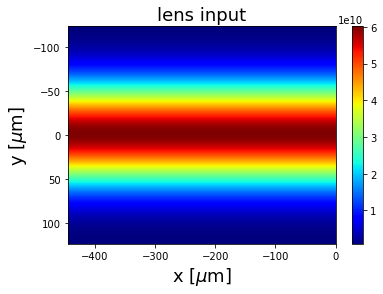

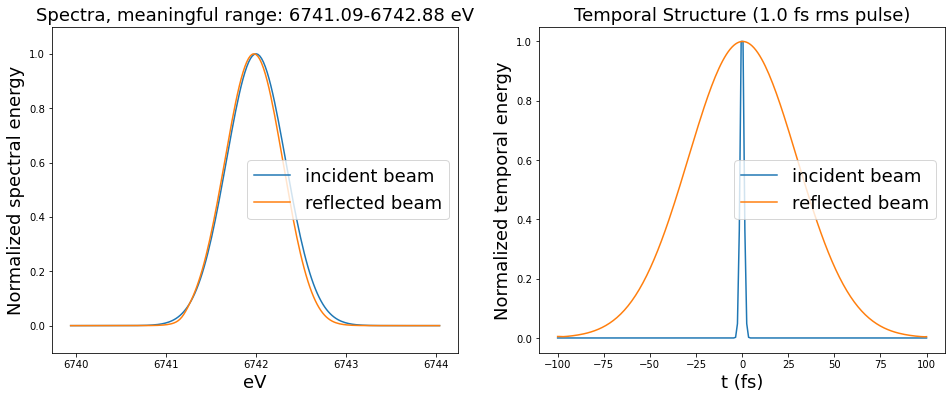

In [853]:
''' plot reflected beam '''
srwl.SetRepresElecField(mwf_reflected._srwl_wf, 't')
[xmin, xmax, ymin, ymax] = mwf_reflected.get_limits()
plt.figure()
plt.imshow(mwf_reflected.get_intensity().sum(axis=-1),cmap='jet',
          extent = [xmin*1e6, xmax*1e6,ymin*1e6,ymax*1e6])
plt.axis('tight')
plt.colorbar()
plt.xlabel(r'x [$\mu$m]',fontsize=18)
plt.ylabel(r'y [$\mu$m]',fontsize=18)
plt.title('lens input',fontsize=18)
srwl.SetRepresElecField(mwf_reflected._srwl_wf, 'f')

''' reflected beam structure '''
# spectra
aw, evI, intIs = get_spectra(mwf)
aw, evR, intRs = get_spectra(mwf_reflected)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(evI, intIs/intIs.max(), label='incident beam')
plt.plot(evR, intRs/intRs.max(), label='reflected beam')
plt.ylim([-0.1,1.1])
plt.legend(fontsize=18)
plt.title('Spectra, meaningful range: {}-{} eV'.format(
    round(evR[aw[0]],2),round(evR[aw[-1]],2)),fontsize=18)
plt.xlabel('eV',fontsize=18)
plt.ylabel('Normalized spectral energy',fontsize=18)

# temporal structure
aw, tR, intRt = get_temporal(mwf_reflected)
normRt = intRt/intRt.max()

if normRt.min()>0.01:
    print('\n\n\nNot enough sampling!!!!')
    print(normRt.min())
    
plt.subplot(1,2,2)
plt.plot(tI*1e15, normIt, label='incident beam')
plt.plot(tR*1e15, normRt, label='reflected beam')
plt.legend(fontsize=18)
plt.title('Temporal Structure ({} fs rms pulse)'.format(
    pulse_duration*1e15),fontsize=18)
plt.xlabel('t (fs)',fontsize=18)
plt.ylabel('Normalized temporal energy',fontsize=18)


In [922]:
trange

2.0678338483020017e-13

In [921]:
def calc_stretching(thetaB, ang_as, range_xy):
    L = range_xy/np.tan(thetaB-ang_as)
    delta = np.cos(thetaB+ang_as)/np.sin(thetaB-ang_as)*range_xy - L
    trange = delta/3e8
    return trange

calc_stretching(thetaB0,ang_as0,range_xy)

2.0216467737086386e-13

R-space


Text(0, 0.5, 'ratio')

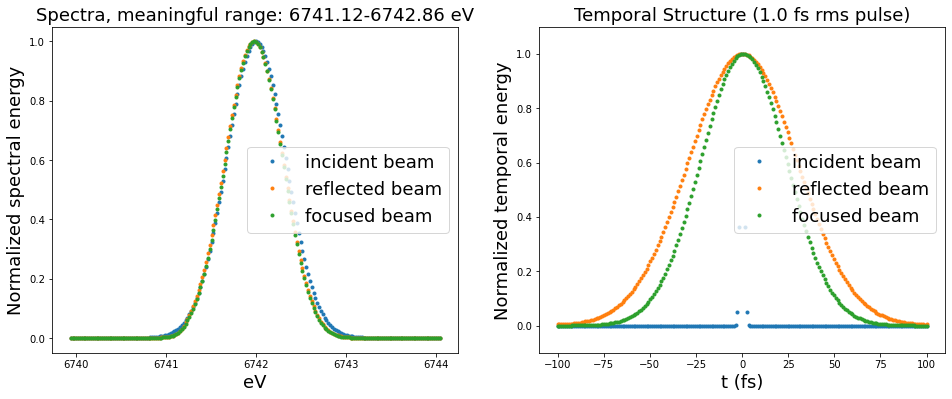

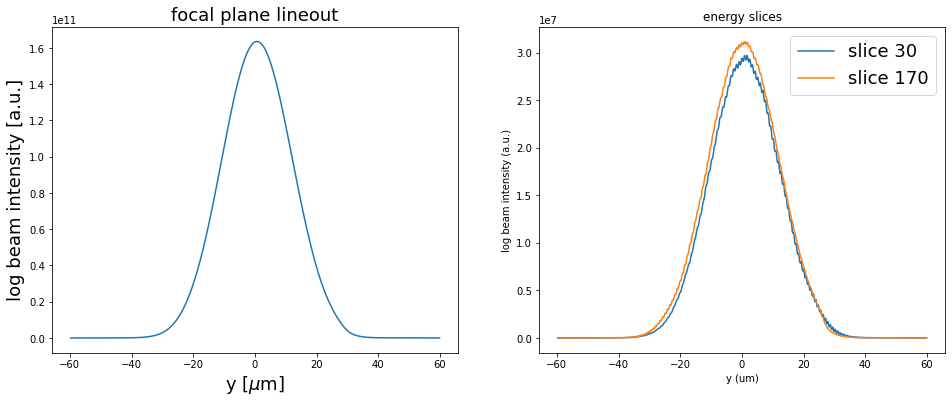

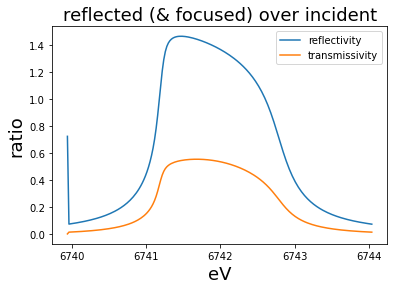

In [854]:
''' plot focused beam '''
if min([mwf_focused.params.nx,mwf_focused.params.nx])>=4:
    # if one dimension is sampled by smaller than 4 points, it's like a 1D simulation and don't plot
    srwl.SetRepresElecField(mwf_focused._srwl_wf, 't')
    [xmin, xmax, ymin, ymax] = mwf_focused.get_limits()
    d_fov = 200e-6
    range_max = ymax-ymin
    if d_fov>= range_max:
        d_fov == range_max
    roi_ratio_y = np.abs(d_fov/(ymax-ymin))
    roiyi = int(ny*(1-roi_ratio_y)/2); roiyf = int(ny*(1+roi_ratio_y)/2)
    ylimi = ymin*roi_ratio_y; ylimf = ymax*roi_ratio_y
    plt.figure(figsize=(16,6))
    plt.imshow(mwf_focused.get_intensity().sum(axis=-1)[roiyi:roiyf,:],cmap='jet',
              extent = [xmin*1e6, xmax*1e6, ylimi*1e6, ylimf*1e6])
    plt.colorbar()
    plt.title('focal plane',fontsize=18)
    plt.xlabel('x [um]',fontsize=18)
    plt.ylabel('y [um]',fontsize=18)

''' focused beam structure '''
# spectra
aw, evF, intFs = get_spectra(mwf_focused)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(evI, intIs/intIs.max(),'.', label='incident beam')
plt.plot(evR, intRs/intRs.max(),'.', label='reflected beam')
plt.plot(evF, intFs/intFs.max(),'.', label='focused beam')
plt.legend(fontsize=18)
plt.title('Spectra, meaningful range: {}-{} eV'.format(
    round(evF[aw[0]],2),round(evF[aw[-1]],2)),fontsize=18)
plt.xlabel('eV',fontsize=18)
plt.ylabel('Normalized spectral energy',fontsize=18)

# temporal structure
aw, tF, intFt = get_temporal(mwf_focused)
normFt = intFt/intFt.max()

if normFt.min()>0.01:
    print('\n\n\nNot enough sampling!!!!')
    print(normFt.min())
    
plt.subplot(1,2,2)
plt.plot(tI*1e15, normIt,'.', label='incident beam')
plt.plot(tR*1e15, normRt,'.', label='reflected beam')
plt.plot(tF*1e15, normFt,'.', label='focused beam')
plt.ylim([-0.1,1.1])
plt.legend(fontsize=18)
plt.title('Temporal Structure ({} fs rms pulse)'.format(
    pulse_duration*1e15),fontsize=18)
plt.xlabel('t (fs)',fontsize=18)
plt.ylabel('Normalized temporal energy',fontsize=18)

''' lineout '''
srwl.SetRepresElecField(mwf_focused._srwl_wf, 't')
[xmin, xmax, ymin, ymax] = mwf_focused.get_limits()
img = mwf_focused.get_intensity().sum(axis=-1)

plt.figure(figsize=(16,6))
yy = np.linspace(ymin,ymax,npointsy)*1e6
index = np.argwhere(np.abs(yy)<60)
yy = yy[index.min():index.max()]
plt.subplot(1,2,1)
plt.plot(yy,img[:,int(npointsx/2)][index.min():index.max()])
plt.xlabel(r'y [$\mu$m]',fontsize=18)
plt.ylabel('log beam intensity [a.u.]',fontsize=18)
plt.title('focal plane lineout',fontsize=18)

''' plot boundary energy slices '''
plt.subplot(1,2,2)
plt.plot(yy, mwf_focused.get_intensity(slice_number=min(aw))[:,int(npointsx/2)][index.min():index.max()],
        label = 'slice {}'.format(min(aw)))
plt.plot(yy, mwf_focused.get_intensity(slice_number=max(aw))[:,int(npointsx/2)][index.min():index.max()],
        label = 'slice {}'.format(max(aw)))
plt.legend(fontsize=18)
plt.title('energy slices')
plt.xlabel('y (um)')
plt.ylabel('log beam intensity (a.u.)')

''' transmission and reflectivity '''
plt.figure()
plt.plot(evI, intRs/intIs,label='reflectivity')
plt.plot(evI, intFs/intIs, label='transmissivity')
plt.legend()
plt.title('reflected (& focused) over incident',fontsize=18)
plt.xlabel('eV',fontsize=18)
plt.ylabel('ratio',fontsize=18)

### theoretical diffraction limit and angular dispersion


In [855]:
''' diffraction limit '''
def E2L(e):
    hbar = 6.582119569e-16
    omega = e/hbar
    frequency = omega /2/np.pi
    wavelength = 3e8/frequency
    return wavelength

wl0 = E2L(ekev*1e3)
thetamax = 2*np.arctan(Lens_width/f_lens)
dlim = wl0/2/n/np.sin(thetamax)
print('diffraction limit {}um'.format(round(dlim*1e6,3)))


diffraction limit 0.153um


sampling time range 200.0fs, photon energy sampling resolution 20.68meV


Text(0, 0.5, 'normalized spectral energy')

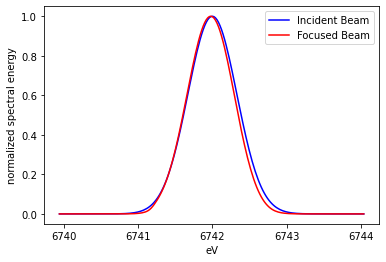

In [856]:
''' sampling frequency '''
hbar = 6.582119569e-16
trange = pulseRange*pulse_duration
dev = 1/trange * 2*np.pi * hbar
print('sampling time range {}fs, photon energy sampling resolution {}meV'.format(round(trange*1e15,2),round(dev*1e3,2)))

''' get frequency axis of incident beam '''
srwl.SetRepresElecField(mwf._srwl_wf, 'f')
mesh = mwf.params.Mesh
dx = (mesh.xMax - mesh.xMin) / (mesh.nx - 1)
dy = (mesh.yMax - mesh.yMin) / (mesh.ny - 1)
int0 = mwf.get_intensity().sum(axis=0).sum(axis=0)
int0_00 = mwf.get_intensity()[int(mesh.ny/2), int(mesh.nx/2),:]
int0max = max(int0)

aw = [a[0] for a in np.argwhere(int0>int0max*0.01)]
int0_mean = int0[min(aw):max(aw)]   # meaningful pulse range
dSlice = (mesh.sliceMax - mesh.sliceMin)/(mesh.nSlices-1)

axis_ev = np.arange(mesh.nSlices) * dSlice + mesh.sliceMin
axis_mean = np.arange(min(aw),max(aw)) * dSlice + mesh.sliceMin


''' get frequency axis of focused beam '''
srwl.SetRepresElecField(mwf_focused._srwl_wf, 'f')
mesh1 = mwf_focused.params.Mesh
dx1 = (mesh.xMax - mesh.xMin) / (mesh.nx - 1)
dy1 = (mesh.yMax - mesh.yMin) / (mesh.ny - 1)
int1 = mwf_focused.get_intensity().sum(axis=0).sum(axis=0)
int1_00 = mwf_focused.get_intensity()[int(mesh.ny/2), int(mesh.nx/2),:]
int1max = max(int1)

aw1 = [a[0] for a in np.argwhere(int1>int1max*0.01)]
int1_mean = int1[min(aw1):max(aw1)]   # meaningful pulse range
dSlice1 = (mesh1.sliceMax - mesh1.sliceMin)/(mesh1.nSlices-1)

axis_ev1 = np.arange(mesh1.nSlices) * dSlice1 + mesh1.sliceMin
axis_mean1 = np.arange(min(aw1),max(aw1)) * dSlice1 + mesh1.sliceMin

plt.figure()
plt.plot(axis_ev, int0/int0.max(),'b',label='Incident Beam')
#plt.plot(axis_mean, int0_mean/int0_mean.max(), 'b.',alpha=0.2)
plt.plot(axis_ev1, int1/int1.max(),'r',label='Focused Beam')
#plt.plot(axis_mean1, int1_mean/int1_mean.max(), 'ro',alpha=0.2)
plt.plot()
plt.legend()
plt.xlabel('eV')
#plt.ylabel('J/eV, normalized to peak')
plt.ylabel('normalized spectral energy')

### range of acceptable photon energy sampling resolution

1. photon energy dev

    The sampling resolution in photon energy equals 2*np.pi * hbar / (pulse_duration * pulseRange). For sufficient sampling, see if each photon energy slice is sampled smooth enough. *** this is also a function of asymmetry angle.

0.7 good
2.3 good
9.0 good
13.8 good
20.7 good
27.6 not good


2. time trange/nz

    The sampling resolution in time equals pulse_duration * pulseRange / nz. For sufficient sampling, equate this to the coherence time of a pulse (0.1fs?) *** move this to after the crystal parameters and calculate how much the beam is stretched, then sample.
    
    
3. calculate Rayleigh range to determine how much further from the focal plane do I want. +- 10 Rayleigh length.


4. document how long it takes to simulate.


5. how to present/ visualize the result.


In [857]:
''' angular dispersion '''
e1 = axis_mean[0]
e2 = axis_mean[-1]

# calculate Bragg angle for each energy
ang_as0 = -np.deg2rad(0)        # asymmetric angle
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as0,_uc=uc)

ang_dif_pl = 0                # diffraction plane angle: 0 (vertical); pi/2 (horizontal)

# crystal orientation
nvx1, nvy1, nvz1 = Temp_Crystal.find_orient(e1,ang_dif_pl)[0][2]
nvx2, nvy2, nvz2 = Temp_Crystal.find_orient(e2,ang_dif_pl)[0][2]

# Bragg angle
thetaB1 = np.arctan(-nvz1/nvy1)+ang_as0
thetaB2 = np.arctan(-nvz2/nvy2)+ang_as0
print("Bragg angles: {} deg".format(np.rad2deg([thetaB1,thetaB2])))

# calculate refractive index for each energy
n1 = 2*d_sp*1e-10*np.sin(thetaB1)/E2L(e1)
n2 = 2*d_sp*1e-10*np.sin(thetaB2)/E2L(e2)
print(n1, n2)

# calculate reflection angle for each energy
def calcThetaO(thetaB, ang_as, n):
    theta1 = np.arcsin(1/n * np.sin(np.pi/2-thetaB+ang_as))
    theta2 = np.arcsin(n * np.sin(theta1-2*ang_as))
    thetaOut = np.pi/2-ang_as-theta2
    return thetaOut

thetaO1 = calcThetaO(thetaB1, ang_as, n1)
thetaO2 = calcThetaO(thetaB2, ang_as, n2)

print('energy separation: {} meV'.format(round((e2-e1)*1e3,2)))
print('Dispersion: {} urad'.format(round((thetaO1-thetaO2)*1e6,4)))
print('Separation: {} um'.format(round(f_lens*(thetaO1-thetaO2)*1e6,2)))

Bragg angles: [17.06015253 17.05505879] deg
0.9996058887955744 0.9996060614853198
energy separation: 1954.62 meV
Dispersion: 88.7315 urad
Separation: 88.73 um


### automate incident beam time slice parameters based on minimum sampling requirement

In [858]:
dt = 1e-16             # time sampling resolution
dev = 20e-3            # photon energy sampling resolution
hbar = 6.582119569e-16

trange = 1/dev * 2*np.pi * hbar   # time sampling range
nz = trange/dt                    # number of slices in z

pulse_duration = 1.e-15           # pulse duration
pulseRange = trange/pulse_duration

In [866]:
''' stretched pulse length '''
ang_as0 = np.deg2rad(-5)        # asymmetric angle
Temp_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as0,_uc=uc)

ang_dif_pl = 0                # diffraction plane angle: 0 (vertical); pi/2 (horizontal)

# crystal orientation
nvx0, nvy0, nvz0 = Temp_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]
thetaB0 = np.arctan(-nvz0/nvy0)+ang_as0

beam_size = theta_fwhm/k*z1

17.056416043312204
-5.0


In [913]:
wl0 = E2L(ekev*1e3)					# wavelength
divergence = wl0/np.pi/sigX			# paraxial beam divergence (rms)
range_test = divergence/2 * z1*3.5


In [859]:
''' crystal parameters '''
d_sp = 3.13557135638           # reflecting plane d-spacing [A]
psi0r = -5.11321939903e-05     # real part of 0th Fourier component of crystal polarizability
psi0i = 3.58887560736e-06      # imaginary part of ""
psi_hr = -2.71341902391e-05    # real part of Hth Fourier component
psi_hi = 2.50565837652e-06     # imaginary part of ""
psi_hbr = -2.71341902391e-05   # real part of -Hth Fourier component
psi_hbi = 2.50565837652e-06    # imaginary part of ""
tc = 0.01                      # crystal thickness
ang_as = -np.deg2rad(0)        # asymmetric angle
uc = 1                         # use case: 1 (Bragg reflection); 2 (Bragg transmission)
#ang = 0.83257236543
#amp_coef = 1.0

OE_Crystal = SRWLOptCryst(d_sp,psi0r,psi0i,psi_hr,psi_hi,psi_hbr,psi_hbi,tc,ang_as,_uc=uc)

''' crystal orientation '''
ang_dif_pl = 0                # diffraction plane angle: 0 (vertical); pi/2 (horizontal)

# outward normal vector to crystal surface
nvx, nvy, nvz = OE_Crystal.find_orient(ekev*1e3,ang_dif_pl)[0][2]

print(nvy, nvz)

0.9560104589307966 -0.293332579872962


In [860]:
# ask Oleg how to input SASE spectrum

In [932]:
k0 = 2*np.pi/wl0
zR = 1/2 * k0 * dlim**2
print(zR)


0.00040148628763767415


### 1. 3 propagation of temporal slices